## Import `tf` Library

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd

## Define Model

$$
\begin{matrix}
\text{Input 1: text}, X_1 & \rightarrow & \text{embed}: E(X_1) & \rightarrow & N_1(E(X_1)) \\
  & & & & \searrow \\
  & & & &          & \oplus \rightarrow N_3 \bigg( \underbrace{N_1(E(X_1))}_\text{text}, \underbrace{N_2(X_2)}_\text{func rating} \bigg) \\
  & & & & \nearrow \\
& & \text{Input 2: function rating}, X_2 & \rightarrow & N_2(X_2) \\
\end{matrix}
$$

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten

# Define function to create the neural network model
def create_nn_model(vocab_size: int, embedding_dim: int, max_length: int, num_of_dense: int) -> Model:
    """
    Creates a neural network model that processes user prompts using an embedding layer,
    concatenates it with function ratings, and passes through dense layers.

    Args:
        vocab_size (int): Size of the vocabulary for embedding.
        embedding_dim (int): Dimensionality of the embedding layer.
        max_length (int): Maximum length of input sequences.
        num_of_dense (int): Number of dense layers before concatenation.

    Returns:
        Model: A compiled TensorFlow model.
    """
    # Text input (user prompt)
    text_input = Input(shape=(max_length,), name="text_input")
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(text_input)
    flatten = Flatten()(embedding)

    # Dense layers for text input
    num_neurons = 2**12  # Start with 4096 neurons
    x = flatten
    for _ in range(num_of_dense):
        num_neurons = max(1, int(num_neurons / 2))  # Ensure integer neurons, minimum of 1
        x = Dense(num_neurons, activation='relu')(x)

    # Numeric input (func_rating)
    func_rating_input = Input(shape=(1,), name="func_rating_input")
    y = Dense(32, activation='relu')(func_rating_input)

    # Concatenate both paths
    concatenated = Concatenate()([x, y])
    # output = Dense(1, activation='linear', name="output")(concatenated)
    output = Dense(6, activation='softmax', name="output")(concatenated)

    # Define and compile the model
    model = Model(inputs=[text_input, func_rating_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

## Prep Data

In [ ]:
# Generate a larger sample dataset with 20 rows
data = {
    "user_prompt": [
        "I have just been on an international flight",
        "How can I improve my sleep quality?",
        "What are the symptoms of vitamin D deficiency?",
        "Best exercises for lower back pain relief",
        "Healthy meal ideas for weight loss",
        "How to reduce stress and anxiety naturally?",
        "What are the benefits of intermittent fasting?",
        "Tips for maintaining healthy skin",
        "How much water should I drink daily?",
        "Best ways to boost immune system",
        "Exercises to improve posture",
        "How to manage time effectively?",
        "Signs and symptoms of dehydration",
        "What foods help lower cholesterol?",
        "How to stay productive while working remotely?",
        "What are the dangers of processed foods?",
        "How to get better sleep without medication?",
        "Ways to increase energy levels naturally",
        "How does meditation help mental health?",
        "Best strategies to quit smoking"
    ],
    "func_rating": [3, 4, 2, 5, 3, 4, 5, 3, 4, 5, 3, 4, 2, 5, 3, 4, 5, 3, 4, 5],
    "custom_rating": [4, 5, 3, 4, 4, 5, 5, 4, 4, 5, 3, 5, 3, 4, 4, 3, 5, 4, 4, 5]
}

# Convert to DataFrame and display
df = pd.DataFrame(data)

When using `to_categorical` function, watch out for unique levels in `custom_rating` column.

In [ ]:
df["custom_rating"].unique()

array([4, 5, 3])

In [ ]:
df.shape

(20, 3)

### Tokenizer to Process Text

In [ ]:
# Tokenize and prepare data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["user_prompt"])
vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(x.split()) for x in df["user_prompt"]])
embedding_dim = 16

# Convert text data into sequences
X_text = tokenizer.texts_to_sequences(df["user_prompt"])
X_text = pad_sequences(X_text, maxlen=max_length, padding='post')
print(X_text.shape)

# Numeric input
X_func_rating = np.array(df["func_rating"]).reshape(-1, 1)
print(X_func_rating.shape)

# Target variable
y = np.array(df["custom_rating"]).reshape(-1, 1)
print(y.shape)

(20, 8)
(20, 1)
(20, 1)


In [ ]:
df["custom_rating"].unique()

array([4, 5, 3])

In [ ]:
from keras.utils import to_categorical

# Assuming y is your array of class labels shaped as (20, 1)
# Convert labels to one-hot encoding
y_one_hot = to_categorical(y)

# Check the new shape of y_one_hot
print(y_one_hot.shape)

## Instantiate Model

In [ ]:
# Create the model
num_of_dense_layers = 3  # Example: 2 dense layers before concatenation
model = create_nn_model(vocab_size, embedding_dim, max_length, num_of_dense_layers)

## Training

In [ ]:
%%time

# Train the model
model.fit(
    {"text_input": X_text, "func_rating_input": X_func_rating},
    y_one_hot,
    epochs=80,
    batch_size=2,
    validation_split=0.1,
    verbose=2
)

Epoch 1/80
9/9 - 3s - 341ms/step - accuracy: 0.2778 - loss: 1.6601 - val_accuracy: 0.5000 - val_loss: 1.1360
Epoch 2/80
9/9 - 0s - 10ms/step - accuracy: 0.4444 - loss: 1.1458 - val_accuracy: 0.5000 - val_loss: 0.8294
Epoch 3/80
9/9 - 0s - 9ms/step - accuracy: 0.6667 - loss: 0.8636 - val_accuracy: 0.5000 - val_loss: 0.8612
Epoch 4/80
9/9 - 0s - 10ms/step - accuracy: 0.7222 - loss: 0.5379 - val_accuracy: 0.5000 - val_loss: 0.5538
Epoch 5/80
9/9 - 0s - 9ms/step - accuracy: 1.0000 - loss: 0.2124 - val_accuracy: 1.0000 - val_loss: 0.3964
Epoch 6/80
9/9 - 0s - 10ms/step - accuracy: 1.0000 - loss: 0.0425 - val_accuracy: 1.0000 - val_loss: 0.2427
Epoch 7/80
9/9 - 0s - 9ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 0.1608
Epoch 8/80
9/9 - 0s - 9ms/step - accuracy: 1.0000 - loss: 5.9476e-04 - val_accuracy: 1.0000 - val_loss: 0.1446
Epoch 9/80
9/9 - 0s - 9ms/step - accuracy: 1.0000 - loss: 3.2127e-04 - val_accuracy: 1.0000 - val_loss: 0.1352
Epoch 10/80
9/9 - 0s - 1

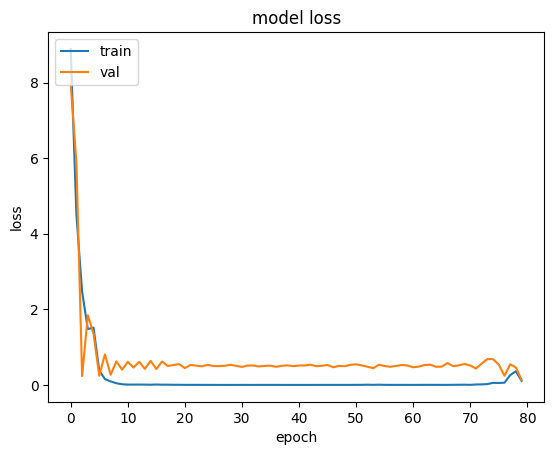

In [ ]:
# Plot error
import matplotlib.pyplot as plt

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Display the model summary
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 8)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 8, 16)          │          1,376 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 128)            │              0 │ embedding_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 2048)           │        264,192 │ flatten_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 1024)           │      2,098,176 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ func_rating_input         │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 512)            │        524,800 │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 32)             │             64 │ func_rating_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 544)            │              0 │ dense_15[0][0],        │
│ (Concatenate)             │                        │                │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1)              │            545 │ concatenate_4[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,667,461 (33.06 MB)

 Trainable params: 2,889,153 (11.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,778,308 (22.04 MB)

## Create Repo on HF

In [ ]:
! pip install --upgrade huggingface_hub

In [ ]:
from huggingface_hub import HfApi

hf_username = "eagle0504"  # Replace with your Hugging Face username
repo_name = "my-tf-nn-model-v6"  # Change this as needed
repo_id = f"{hf_username}/{repo_name}"

api = HfApi()

# Create the repository
api.create_repo(repo_id=repo_id, exist_ok=True)  # exist_ok=True prevents errors if the repo already exists

print(f"Repository created: https://huggingface.co/{repo_id}")

Repository created: https://huggingface.co/eagle0504/my-tf-nn-model-v6


## Push Artifacts on HF

In [ ]:
import pickle
import os
from huggingface_hub import HfApi
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

# Define save directory
model_dir = "./saved_model"
os.makedirs(model_dir, exist_ok=True)

# Save the model
model_path = os.path.join(model_dir, "model.keras")
model.save(model_path)

# Save the tokenizer as a pickle file
tokenizer_path = os.path.join(model_dir, "tokenizer.pkl")
with open(tokenizer_path, "wb") as f:
    pickle.dump(tokenizer, f)

# Upload model and tokenizer to Hugging Face
repo_id = f"eagle0504/{repo_name}"  # Change as needed
api = HfApi()

api.upload_file(path_or_fileobj=model_path, path_in_repo="model.keras", repo_id=repo_id)
api.upload_file(path_or_fileobj=tokenizer_path, path_in_repo="tokenizer.pkl", repo_id=repo_id)

print(f"Model and tokenizer successfully pushed to: https://huggingface.co/{repo_id}")

model.keras:   0%|          | 0.00/34.8M [00:00<?, ?B/s]

tokenizer.pkl:   0%|          | 0.00/2.65k [00:00<?, ?B/s]

Model and tokenizer successfully pushed to: https://huggingface.co/eagle0504/my-tf-nn-model-v6


## Download Model Artifact from HF

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from huggingface_hub import hf_hub_download

# Set Keras backend to JAX (Optional, only needed if you want to experiment with JAX backend)
os.environ["KERAS_BACKEND"] = "jax"

# Define repo ID and model filename
# repo_id = "eagle0504/my-tf-nn-model" # we already defined it above
filename = "model.keras"  # Ensure this matches what was uploaded

# Download the model
model_path = hf_hub_download(repo_id=repo_id, filename=filename)

# Load the Keras model
new_model = keras.models.load_model(model_path)

print("Model loaded successfully!")

model.keras:   0%|          | 0.00/34.8M [00:00<?, ?B/s]

Model loaded successfully!


In [ ]:
new_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 8)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 8, 16)          │          1,376 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 128)            │              0 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 2048)           │        264,192 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 1024)           │      2,098,176 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ func_rating_input         │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 512)            │        524,800 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 32)             │             64 │ func_rating_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 544)            │              0 │ dense_14[0][0],        │
│ (Concatenate)             │                        │                │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 6)              │          3,270 │ concatenate_3[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,675,636 (33.09 MB)

 Trainable params: 2,891,878 (11.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,783,758 (22.06 MB)

## Local Inference

In [ ]:
import pickle
from huggingface_hub import hf_hub_download
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Define repo details
# repo_id = "eagle0504/my-tf-nn-model" # we already defined above

# Download model
# model_path = hf_hub_download(repo_id=repo_id, filename="model.keras")
# new_model = keras.models.load_model(model_path)

# Download tokenizer
tokenizer_path = hf_hub_download(repo_id=repo_id, filename="tokenizer.pkl")

# Load the tokenizer
with open(tokenizer_path, "rb") as f:
    tokenizer = pickle.load(f)

print("Model and tokenizer loaded successfully!")

# Sample test data
test_texts = [
    "How to improve focus and concentration?",
    "What are the side effects of lack of sleep?",
]

# Preprocess test data using the loaded tokenizer
max_length = model.input_shape[0][1]  # Get max_length from model input shape
X_text_test = tokenizer.texts_to_sequences(test_texts)
X_text_test = pad_sequences(X_text_test, maxlen=max_length, padding='post')

# Dummy numeric input (func_rating)
X_func_test = np.array([5, 4]).reshape(-1, 1)

# Make predictions
predictions = new_model.predict({"text_input": X_text_test, "func_rating_input": X_func_test})

# Display results
for i, text in enumerate(test_texts):
    print(f"Prompt: {text}")
    print(f"Predicted Rating: {predictions[i][0]:.2f}")
    print("-" * 50)

tokenizer.pkl:   0%|          | 0.00/2.65k [00:00<?, ?B/s]

Model and tokenizer loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
Prompt: How to improve focus and concentration?
Predicted Rating: 0.00
--------------------------------------------------
Prompt: What are the side effects of lack of sleep?
Predicted Rating: 0.00
--------------------------------------------------
